# Setting

In [1]:
import bt
import FinanceDataReader as fdr
import pandas as pd

In [2]:
from pypfopt import EfficientFrontier, EfficientSemivariance, EfficientCVaR, EfficientCDaR
from pypfopt import risk_models
from pypfopt import expected_returns

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams["font.family"] = 'NanumBarunGothic'

In [4]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [84]:
path_data = 'data'

metrics = [
    'total_return', 'cagr', 
    'max_drawdown', 'avg_drawdown', 'avg_drawdown_days', 
    'daily_vol', 'daily_sharpe', 'daily_sortino', 
    'monthly_vol', 'monthly_sharpe', 'monthly_sortino'
]

In [6]:
def buy_and_hold(df, names=None, name_stg=None):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if names is not None:
        if not isinstance(names, list):
            names = [names]
        cols = df.columns
        if len(cols) == len(names):
            df = df.rename(columns=dict(zip(cols, names)))
        else:
            print('WARNING: check num of names')

    if name_stg is None:
        name_stg = names[0]
        
    strategy = bt.Strategy(name_stg, [
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.RunOnce(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(strategy, df)



def backtest(dfs, weights=None, name='portfolio', period='M', **kwargs):
    if weights is None:
        cols = dfs.columns
        weights = dict(zip(cols, [1]*len(cols)))

    if period == 'W':
        run_period = bt.algos.RunWeekly()
    elif period == 'Q':
        run_period = bt.algos.RunQuarterly()
    elif period == 'Y':
        run_period = bt.algos.RunYearly()
    else: # default montly
        run_period = bt.algos.RunMonthly()
        
    strategy = bt.Strategy(name, [
        bt.algos.SelectAll(),
        bt.algos.WeighSpecified(**weights),
        run_period,
        bt.algos.Rebalance()
    ])
    return bt.Backtest(strategy, dfs, **kwargs)



def get_start_dates(dfs, symbol_name=None):
    """
    symbol_name: dict of symbols to names
    """
    df = dfs.apply(lambda x: x[x.notna()].index.min()).to_frame('start date')
    if symbol_name is not None:
        df = pd.Series(symbol_name).to_frame('name').join(df)
    return df.sort_values('start date')



def valuate_bond(face, rate, year, ytm, n_pay=1):
    """
    face: face value
    rate: coupon rate (annual)
    year: years to maturity
    ytm: discount rate (annual)
    n_pay: number of payments per year
    """
    c = face * rate / n_pay
    vc = 0
    r_discount = ytm/n_pay
    # calc The present value of expected cash flows
    for t in range(1, year*n_pay+1):
        vc += c/(1+r_discount)**t
    # the present value of the face value of the bond added
    return vc + face/(1+r_discount)**(year*n_pay)


# Data

## ETF

In [7]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목
df_sym.head()

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
0,459580,6,KODEX CD금리액티브(합성),1038565,2,95,0.01,1038566.0,0.8953,331333,344111,88015
1,357870,6,TIGER CD금리투자KIS(합성),54440,2,5,0.01,54436.0,0.8896,144243,7852,72873
2,069500,1,KODEX 200,36965,2,50,0.14,37040.0,2.4221,2441522,90161,62711
3,423160,6,KODEX KOFR금리액티브(합성),107045,2,5,0.00,107033.0,0.9097,33292,3563,51992
4,449170,6,TIGER KOFR금리액티브(합성),105560,2,5,0.00,105572.0,0.8888,35468,3744,36985


In [85]:
cond = df_sym.Name.str.contains('채권')
cond = cond | df_sym.Name.str.contains('국고채')
cond = cond | df_sym.Name.str.contains('국채')
#cond = cond & df_etf.Name.str.contains('미국')
cond = cond & ~df_sym.Name.str.contains('액티브')

#cond = df_etf.Name.str.contains('S&P')

#cond = df_etf.Name.str.contains('금현물')

df_sym.loc[cond].sort_values('MarCap', ascending=False)

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
21,214980,6,KODEX 단기채권PLUS,110795,2,25,0.02,110785.0,0.9153,13622,1509,12848
44,153130,6,KODEX 단기채권,109855,2,10,0.01,109853.0,0.8537,21790,2393,7373
64,148070,6,KOSEF 국고채10년,112610,2,410,0.37,112573.0,1.2270,9711,1091,4932
73,385560,6,KBSTAR KIS국고채30년Enhanced,72255,2,785,1.10,72261.0,2.4239,56207,4043,3988
75,365780,6,ACE 국고채10년,88490,2,315,0.36,88487.0,1.1372,3522,311,3884
76,114260,6,KODEX 국고채3년,59860,2,60,0.10,59853.0,0.7744,33593,2010,3861
90,302190,6,TIGER 중장기국채,50530,2,130,0.26,50528.0,0.9287,5472,276,3295
91,304660,6,KODEX 미국30년국채울트라선물(H),8005,2,60,0.76,7999.0,-2.6156,295897,2365,3290
99,472870,6,KBSTAR 미국30년국채엔화노출(합성 H),8805,2,20,0.23,8821.0,-5.7281,619074,5440,2963
147,473330,6,SOL 미국30년국채커버드콜(합성),9940,2,20,0.20,9935.0,1.3665,428755,4261,1680


In [17]:
symbols = ['273130', '453850', '284430', '069500', '379800', '411060', '305080', '304660', '148070', '261220']
names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)'}

In [18]:
start_data = '2000-01-01'
df_etf = fdr.DataReader(','.join(symbols), start_data)
df_etf.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070,261220
Date,,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN,NaN


*start date of each etf*

In [20]:
df = get_start_dates(df_etf, names)
df.sort_values('start date')

,name,start date
069500,KODEX 200,2002-10-14
148070,KOSEF 국고채10년,2011-10-20
261220,KODEX WTI원유선물(H),2016-12-27
273130,KODEX 종합채권(AA-이상)액티브,2017-06-29
284430,KODEX 200미국채혼합,2017-11-30
305080,TIGER 미국채10년선물,2018-08-30
304660,KODEX 미국30년국채울트라선물(H),2018-09-12
379800,KODEX 미국S&P500TR,2021-04-09
411060,ACE KRX금현물,2021-12-15
453850,ACE 미국30년국채액티브(H),2023-03-14


In [21]:
df_etf = df_etf.loc[df['start date'].min():]

file = 'etfs_selected_240611.csv'
df_etf.to_csv(f'{path_data}/{file}')

## Economic

In [23]:
col = 'Adj Close'

df_snp = fdr.DataReader('S&P500', start_data)[col]
df_gold = fdr.DataReader('GC=F', start_data)[col] # gold
df_wti = fdr.DataReader('CL=F', start_data)[col] # WTI유 선물 Crude Oil (NYMEX)
df_us10 = fdr.DataReader('US10YT', start_data)[col] # 10년 만기 미국국채 수익률
df_us30 = fdr.DataReader('US30YT', start_data)[col] # 30년 만기 미국국채 수익률

In [45]:
df_eco = (df_snp.to_frame('S&P')
      .join(df_gold.to_frame('Gold'))
      .join(df_wti.to_frame('WTI'))
      .join(df_us10.to_frame('US10YT'))
      .join(df_us30.to_frame('US30YT'))
      .join(df_etf['069500'].to_frame('KOSPI'))
     )
df_eco.index = pd.to_datetime(df_eco.index)
df_eco.head()

,S&P,Gold,WTI,US10YT,US30YT,KOSPI
Date,,,,,,
2000-01-03,1455.219971,NaN,NaN,6.548,6.598,NaN
2000-01-04,1399.420044,NaN,NaN,6.485,6.532,NaN
2000-01-05,1402.109985,NaN,NaN,6.599,6.631,NaN
2000-01-06,1403.449951,NaN,NaN,6.549,6.572,NaN
2000-01-07,1441.469971,NaN,NaN,6.504,6.537,NaN


In [46]:
df = get_start_dates(df_eco)
df

,start date
S&P,2000-01-03
US10YT,2000-01-03
US30YT,2000-01-03
WTI,2000-08-23
Gold,2000-08-30
KOSPI,2002-10-14


In [48]:
df_eco = df_eco.loc[df['start date'].min():]

file = 'economic_data_240610.csv'
df_eco.to_csv(f'{path_data}/{file}')

## Load

In [7]:
file = 'etfs_selected_240611.csv'
df_etf = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_etf.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070,261220
Date,,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
file = 'economic_data_240610.csv'
df_eco = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_eco.head()

,S&P,Gold,WTI,US10YT,US30YT,KOSPI
Date,,,,,,
2000-01-03,1455.219971,NaN,NaN,6.548,6.598,NaN
2000-01-04,1399.420044,NaN,NaN,6.485,6.532,NaN
2000-01-05,1402.109985,NaN,NaN,6.599,6.631,NaN
2000-01-06,1403.449951,NaN,NaN,6.549,6.572,NaN
2000-01-07,1441.469971,NaN,NaN,6.504,6.537,NaN


In [9]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

symbols = df_etf.columns
etf_names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
etf_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)'}

In [10]:
commissions = {
    '069500': 0.15, 
    '273130': 0.045, 
    '379800': 0.009,
    '148070': 0.050,
    '411060': 0.500,
    '284430': 0.310,
    '453850': 0.050,
    '304660': 0.260,
    '305080': 0.250,
    '261220': 0.310
}
{etf_names[k]:v for k,v in commissions.items()}

{'KODEX 200': 0.15,
 'KODEX 종합채권(AA-이상)액티브': 0.045,
 'KODEX 미국S&P500TR': 0.009,
 'KOSEF 국고채10년': 0.05,
 'ACE KRX금현물': 0.5,
 'KODEX 200미국채혼합': 0.31,
 'ACE 미국30년국채액티브(H)': 0.05,
 'KODEX 미국30년국채울트라선물(H)': 0.26,
 'TIGER 미국채10년선물': 0.25,
 'KODEX WTI원유선물(H)': 0.31}

# Calibration

## Bond

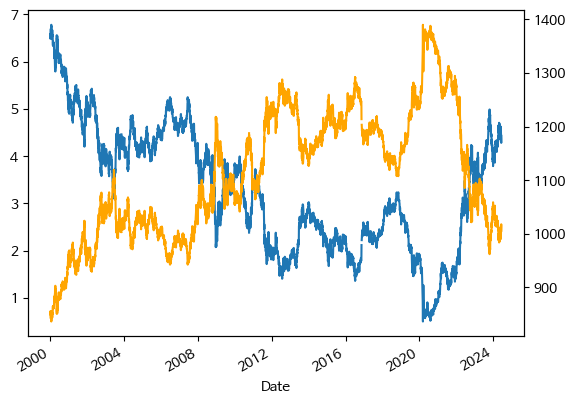

In [19]:
col = 'US10YT'
ax = df_eco[col].plot()
ax2 = ax.twinx()
_ = df_eco[col].apply(lambda x: valuate_bond(1000, 0.045, 10, x/100, 2)).plot(ax=ax2, c='orange')

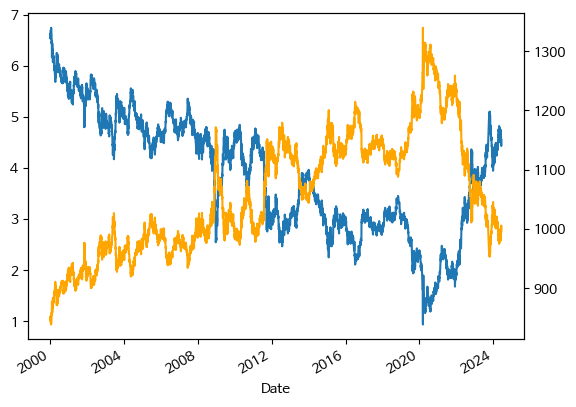

In [20]:
col = 'US30YT'
ax = df_eco[col].plot()
ax2 = ax.twinx()
_ = df_eco[col].apply(lambda x: valuate_bond(1000, 0.045, 10, x/100, 2)).plot(ax=ax2, c='orange')

In [21]:
cols = ['US10YT', 'US30YT']
df_eco[cols] = df_eco[cols].apply(lambda x: valuate_bond(1000, 0.045, 10, x/100, 2))

## ETF

In [22]:
df = get_start_dates(df_etf, etf_names)
df.sort_values('start date')

,name,start date
069500,KODEX 200,2002-10-14
148070,KOSEF 국고채10년,2011-10-20
261220,KODEX WTI원유선물(H),2016-12-27
273130,KODEX 종합채권(AA-이상)액티브,2017-06-29
284430,KODEX 200미국채혼합,2017-11-30
305080,TIGER 미국채10년선물,2018-08-30
304660,KODEX 미국30년국채울트라선물(H),2018-09-12
379800,KODEX 미국S&P500TR,2021-04-09
411060,ACE KRX금현물,2021-12-15
453850,ACE 미국30년국채액티브(H),2023-03-14


In [23]:
start_date = '2011-10-20'
end_date = '2021-12-15'
val_date = '2021-12-16'

In [24]:
candi = ['069500', '148070', '261220', '305080', 
         '304660',
         #'453850',
         '379800', '411060']
{x:etf_names[x] for x in candi}

{'069500': 'KODEX 200',
 '148070': 'KOSEF 국고채10년',
 '261220': 'KODEX WTI원유선물(H)',
 '305080': 'TIGER 미국채10년선물',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '379800': 'KODEX 미국S&P500TR',
 '411060': 'ACE KRX금현물'}

In [25]:
df_eco.columns

Index(['S&P', 'Gold', 'WTI', 'US10YT', 'US30YT', 'KOSPI'], dtype='object')

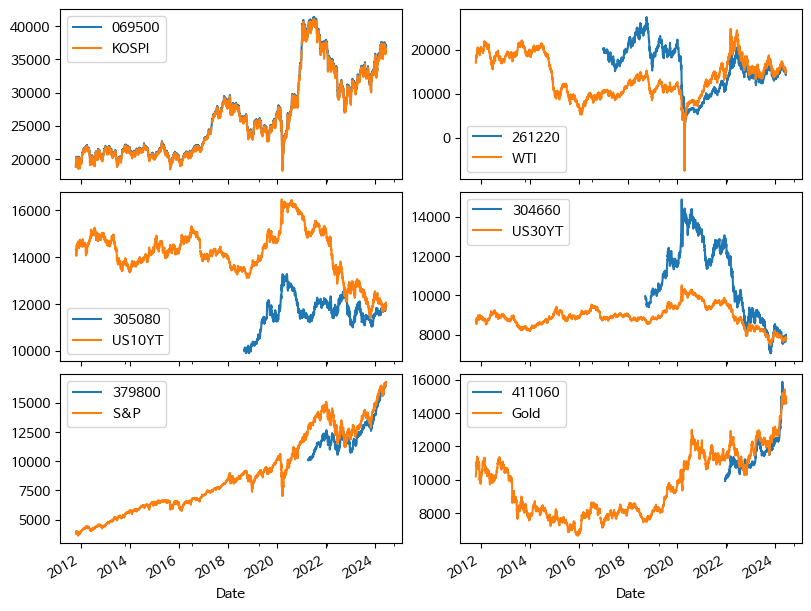

In [26]:
import matplotlib.pyplot as plt

def plot(s1, s2, ax):
    _ = s1.plot(ax=ax)
    _ = s2.apply(lambda x: x*s1[-1]/s2[-1]).plot(ax=ax)
    ax.legend()


cols_pair = [
    [['069500', 'KOSPI'], ['261220', 'WTI']],
    [['305080', 'US10YT'],['304660', 'US30YT']],
    [['379800', 'S&P'],['411060', 'Gold']]
]

n_rows = 3
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(8,6), sharex=True)

for i in range(n_rows):
    for j in range(n_cols):
        ax = axs[i][j]
        c1, c2 = cols_pair[i][j]
        s1 = df_etf.loc[start_date:, c1].dropna()
        s2 = df_eco.loc[start_date:, c2]
        plot(s1, s2, ax)

In [27]:
cols = ['069500','148070']
df_ast = df_etf.loc[start_date:end_date, cols]

for i in range(n_rows):
    for j in range(n_cols):
        if i==0 and j==0:
            continue
        cols = cols_pair[i][j]
        df = df_eco.loc[start_date:end_date, cols[1]]
        df_ast[f'{cols[1]}_c'] = df.mul(df_etf.loc[end_date, cols[0]] / df[-1])
        df_ast

df_ast

,069500,148070,WTI_c,US10YT_c,US30YT_c,S&P_c,Gold_c
Date,,,,,,,
2011-10-20,18934,80424.0,13149.463713,11428.361666,11485.457735,3134.051281,9080.998216
2011-10-21,19252,80066.0,13473.190087,11406.655997,11437.878289,3192.998914,9211.700319
2011-10-24,19934,79791.0,14069.771060,11377.477250,11413.712029,3234.102257,9304.093511
2011-10-25,19883,79948.0,14362.666644,11477.614755,11538.912582,3169.275568,9575.075452
2011-10-26,19914,80063.0,13904.824686,11406.655997,11463.971355,3202.668808,9705.214312
...,...,...,...,...,...,...,...
2021-12-09,37676,115155.0,10935.790730,12105.710962,12818.283831,12035.665985,9997.604676
2021-12-10,37470,114978.0,11048.323621,12103.689449,12799.139008,12150.595444,10044.364847
2021-12-13,37499,115108.0,10989.744997,12169.591526,12875.920373,12039.585567,10063.519646


In [28]:
c = {x:etf_names[x] for x in candi}
pd.Series(c, name='name').to_frame().join(df_etf.loc[end_date].to_frame('price'))

,name,price
069500,KODEX 200,37296.0
148070,KOSEF 국고채10년,115310.0
261220,KODEX WTI원유선물(H),10925.0
305080,TIGER 미국채10년선물,12130.0
304660,KODEX 미국30년국채울트라선물(H),12830.0
379800,KODEX 미국S&P500TR,12145.0
411060,ACE KRX금현물,9930.0


# Optimization

## Setting

In [29]:
df_ast.isna().sum()

069500       0
148070       0
WTI_c       78
US10YT_c    77
US30YT_c    77
S&P_c       76
Gold_c      79
dtype: int64

In [30]:
df_ast = df_ast.fillna(method='ffill')

Baseline

In [31]:
candi

['069500', '148070', '261220', '305080', '304660', '379800', '411060']

In [32]:
pf_dict = dict()
wt_dict = dict()

In [33]:
col = '069500'
bt_res = buy_and_hold(df_ast[col], col)

pf_dict[col] = bt_res
wt_dict[col] = dict(zip(candi, [1,0,0,0,0,0]))

In [34]:
results = bt.run(*pf_dict.values())

In [35]:
results.stats.loc[metrics]

,069500
total_return,0.954824
cagr,0.068217
max_drawdown,-0.377091
avg_drawdown,-0.035118
avg_drawdown_days,62.964286
daily_vol,0.160396
daily_sharpe,0.500909
daily_sortino,0.816027
monthly_vol,0.143099
monthly_sharpe,0.488945


## MeanVar

In [36]:
pf_tmp = dict()
pf_tmp['069500'] = pf_dict['069500']
wt_tmp = dict()

In [37]:
df = df_ast

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

opt = EfficientFrontier(mu, S)

# Optimize for maximal Sharpe ratio
_ = opt.max_sharpe()

weights = opt.clean_weights()
print(weights)

_ = opt.portfolio_performance(verbose=True)

name = 'MeanVar1'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.06305, '148070': 0.577, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.09391, 'S&P_c': 0.26605, 'Gold_c': 0.0})
Expected annual return: 6.6%
Annual volatility: 5.1%
Sharpe Ratio: 0.89


In [38]:
opt = EfficientFrontier(mu, S)
_ = opt.min_volatility()
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'MeanVar2'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.05307, '148070': 0.53746, 'WTI_c': 0.00099, 'US10YT_c': 0.11546, 'US30YT_c': 0.21545, 'S&P_c': 0.07758, 'Gold_c': 0.0})
Expected annual return: 3.8%
Annual volatility: 3.3%
Sharpe Ratio: 0.55


In [39]:
target_return = 0.09
opt = EfficientFrontier(mu, S)
opt.efficient_return(target_return)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'MeanVar3'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.06603, '148070': 0.4687, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.0, 'S&P_c': 0.46527, 'Gold_c': 0.0})
Expected annual return: 9.0%
Annual volatility: 8.2%
Sharpe Ratio: 0.85


In [40]:
target_volatility = 0.05
opt = EfficientFrontier(mu, S)
opt.efficient_risk(target_volatility)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'MeanVar4'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.06259, '148070': 0.57555, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.10491, 'S&P_c': 0.25694, 'Gold_c': 0.0})
Expected annual return: 6.4%
Annual volatility: 5.0%
Sharpe Ratio: 0.89


In [41]:
results = bt.run(*pf_tmp.values())
results.stats.loc[metrics]

,069500,MeanVar1,MeanVar2,MeanVar3,MeanVar4
total_return,0.954824,0.879472,0.433788,1.351177,0.855722
cagr,0.068217,0.064091,0.03611,0.08781,0.06276
max_drawdown,-0.377091,-0.119706,-0.05855,-0.190991,-0.113522
avg_drawdown,-0.035118,-0.006291,-0.005396,-0.008639,-0.006037
avg_drawdown_days,62.964286,16.855556,29.801802,14.935961,16.565217
daily_vol,0.160396,0.048936,0.031024,0.079887,0.047554
daily_sharpe,0.500909,1.322812,1.184899,1.117615,1.332938
daily_sortino,0.816027,2.087694,1.894445,1.735896,2.101769
monthly_vol,0.143099,0.043261,0.033391,0.066287,0.042296
monthly_sharpe,0.488945,1.435321,1.068014,1.280201,1.438054


In [42]:
print(wt_tmp['MeanVar1'])
print(wt_tmp['MeanVar4'])

OrderedDict({'069500': 0.06305, '148070': 0.577, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.09391, 'S&P_c': 0.26605, 'Gold_c': 0.0})
OrderedDict({'069500': 0.06259, '148070': 0.57555, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.10491, 'S&P_c': 0.25694, 'Gold_c': 0.0})


In [43]:
pf_dict['MeanVar'] = pf_tmp['MeanVar1']
wt_dict['MeanVar'] = wt_tmp['MeanVar1']

## SemiVariance

In [44]:
pf_tmp = dict()
pf_tmp['069500'] = pf_dict['069500']
wt_tmp = dict()

In [45]:
df = df_ast
mu = expected_returns.mean_historical_return(df)
S = expected_returns.returns_from_prices(df)

In [46]:
target = 0.09
opt = EfficientSemivariance(mu, S)
opt.efficient_return(target)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'SemiVar1'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.02012, '148070': 0.50045, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.0, 'S&P_c': 0.47944, 'Gold_c': 0.0})
Expected annual return: 9.0%
Annual semi-deviation: 5.8%
Sortino Ratio: 1.21


In [47]:
opt = EfficientSemivariance(mu, S)
opt.min_semivariance()
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'SemiVar2'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.16072, '148070': 0.17385, 'WTI_c': 0.0, 'US10YT_c': 0.17289, 'US30YT_c': 0.17312, 'S&P_c': 0.15933, 'Gold_c': 0.16009})
Expected annual return: 4.6%
Annual semi-deviation: 3.6%
Sortino Ratio: 0.70


In [48]:
results = bt.run(*pf_tmp.values())
results.stats.loc[metrics]

,069500,SemiVar1,SemiVar2
total_return,0.954824,1.364353,0.582624
cagr,0.068217,0.088409,0.046234
max_drawdown,-0.377091,-0.181306,-0.104346
avg_drawdown,-0.035118,-0.007914,-0.009144
avg_drawdown_days,62.964286,13.917808,34.020408
daily_vol,0.160396,0.080221,0.049122
daily_sharpe,0.500909,1.1203,0.965574
daily_sortino,0.816027,1.749861,1.538748
monthly_vol,0.143099,0.064079,0.051666
monthly_sharpe,0.488945,1.33418,0.853217


In [49]:
print(wt_tmp['SemiVar1'])
print(wt_tmp['SemiVar2'])

OrderedDict({'069500': 0.02012, '148070': 0.50045, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.0, 'S&P_c': 0.47944, 'Gold_c': 0.0})
OrderedDict({'069500': 0.16072, '148070': 0.17385, 'WTI_c': 0.0, 'US10YT_c': 0.17289, 'US30YT_c': 0.17312, 'S&P_c': 0.15933, 'Gold_c': 0.16009})


In [50]:
pf_dict['SemiVar'] = pf_tmp['SemiVar1']
wt_dict['SemiVar'] = wt_tmp['SemiVar1']

In [51]:
wt_dict.keys()

dict_keys(['069500', 'MeanVar', 'SemiVar'])

## CVaR

In [52]:
pf_tmp = dict()
pf_tmp['069500'] = pf_dict['069500']
wt_tmp = dict()

In [53]:
df = df_ast
mu = expected_returns.mean_historical_return(df)
S = expected_returns.returns_from_prices(df)

In [54]:
target = 0.09
opt = EfficientCVaR(mu, S)
opt.efficient_return(target)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'CVaR1'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.03828, '148070': 0.48789, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.0, 'S&P_c': 0.47383, 'Gold_c': 0.0})
Expected annual return: 9.0%
Conditional Value at Risk: 1.24%


In [55]:
opt = EfficientCVaR(mu, S)
_ = opt.min_cvar()
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'CVaR2'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.03185, '148070': 0.56488, 'WTI_c': 0.00078, 'US10YT_c': 0.15968, 'US30YT_c': 0.16027, 'S&P_c': 0.07697, 'Gold_c': 0.00557})
Expected annual return: 3.7%
Conditional Value at Risk: 0.48%


In [56]:
results = bt.run(*pf_tmp.values())
results.stats.loc[metrics]

,069500,CVaR1,CVaR2
total_return,0.954824,1.389786,0.411795
cagr,0.068217,0.089556,0.034535
max_drawdown,-0.377091,-0.180746,-0.057214
avg_drawdown,-0.035118,-0.008257,-0.00532
avg_drawdown_days,62.964286,14.390476,32.281553
daily_vol,0.160396,0.079722,0.030533
daily_sharpe,0.500909,1.140331,1.152503
daily_sortino,0.816027,1.78012,1.868421
monthly_vol,0.143099,0.064634,0.033094
monthly_sharpe,0.488945,1.33792,1.035439


In [57]:
pf_dict['CVaR'] = pf_tmp['CVaR1']
wt_dict['CVaR'] = wt_tmp['CVaR1']

## CDaR

In [58]:
pf_tmp = dict()
pf_tmp['069500'] = pf_dict['069500']
wt_tmp = dict()

In [59]:
df = df_ast
mu = expected_returns.mean_historical_return(df)
S = expected_returns.returns_from_prices(df)

In [60]:
target = 0.09
opt = EfficientCDaR(mu, S)
opt.efficient_return(target)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'CDaR1'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.0, '148070': 0.51435, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.0, 'S&P_c': 0.48565, 'Gold_c': 0.0})
Expected annual return: 9.0%
Conditional Drawdown at Risk: 6.22%


In [61]:
opt = EfficientCDaR(mu, S)
_ = opt.min_cdar()
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

name = 'CDaR2'
pf_tmp[name] = backtest(df, weights, name)
wt_tmp[name] = weights

OrderedDict({'069500': 0.0, '148070': 0.4684, 'WTI_c': 0.00093, 'US10YT_c': 0.0, 'US30YT_c': 0.25317, 'S&P_c': 0.27751, 'Gold_c': 0.0})
Expected annual return: 6.1%
Conditional Drawdown at Risk: 3.96%


In [62]:
results = bt.run(*pf_tmp.values())
results.stats.loc[metrics]

,069500,CDaR1,CDaR2
total_return,0.954824,1.364609,0.809126
cagr,0.068217,0.08842,0.060102
max_drawdown,-0.377091,-0.178106,-0.093395
avg_drawdown,-0.035118,-0.007956,-0.00522
avg_drawdown_days,62.964286,14.213953,15.756477
daily_vol,0.160396,0.08076,0.045367
daily_sharpe,0.500909,1.113501,1.33849
daily_sortino,0.816027,1.745248,2.11366
monthly_vol,0.143099,0.063823,0.039723
monthly_sharpe,0.488945,1.341041,1.471896


In [63]:
pf_dict['CDaR'] = pf_tmp['CDaR1']
wt_dict['CDaR'] = wt_tmp['CDaR1']

In [64]:
pf_dict

{'069500': <bt.backtest.Backtest at 0x79bb88bfd250>,
 'MeanVar': <bt.backtest.Backtest at 0x79bb88bd52e0>,
 'SemiVar': <bt.backtest.Backtest at 0x79bb881752e0>,
 'CVaR': <bt.backtest.Backtest at 0x79bb8b955df0>,
 'CDaR': <bt.backtest.Backtest at 0x79bb88d01370>}

In [65]:
wt_dict.keys()

dict_keys(['069500', 'MeanVar', 'SemiVar', 'CVaR', 'CDaR'])

## Compare

In [66]:
results = bt.run(*pf_dict.values())

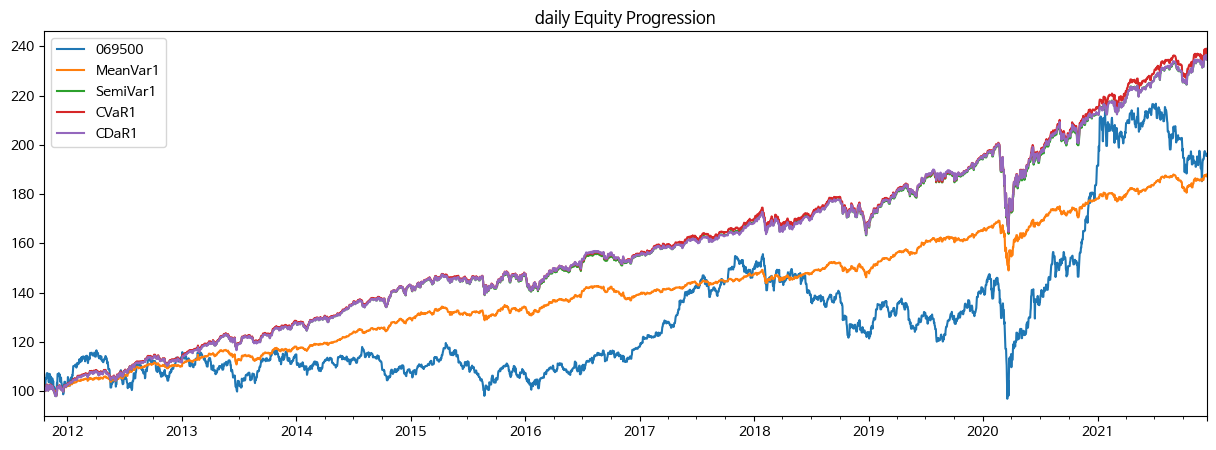

In [67]:
results.plot(freq='d');

In [68]:
results.stats.loc[metrics]

,069500,MeanVar1,SemiVar1,CVaR1,CDaR1
total_return,0.954824,0.879472,1.364353,1.389786,1.364609
cagr,0.068217,0.064091,0.088409,0.089556,0.08842
max_drawdown,-0.377091,-0.119706,-0.181306,-0.180746,-0.178106
avg_drawdown,-0.035118,-0.006291,-0.007914,-0.008257,-0.007956
avg_drawdown_days,62.964286,16.855556,13.917808,14.390476,14.213953
daily_vol,0.160396,0.048936,0.080221,0.079722,0.08076
daily_sharpe,0.500909,1.322812,1.1203,1.140331,1.113501
daily_sortino,0.816027,2.087694,1.749861,1.78012,1.745248
monthly_vol,0.143099,0.043261,0.064079,0.064634,0.063823
monthly_sharpe,0.488945,1.435321,1.33418,1.33792,1.341041


In [71]:
import pickle

file = 'weights_etf.pkl'
with open(file,'wb') as f:
    pickle.dump(wt_dict, f)

# Validation

In [86]:
import pickle

file = 'weights_etf.pkl'
with open(file,'rb') as f:
    wt_dict = pickle.load(f)

In [87]:
start_date = '2011-10-20'
end_date = '2021-12-15'
val_date = '2021-12-16'

In [88]:
candi = ['069500', '148070', '261220', '305080', 
         '304660',
         #'453850',
         '379800', '411060']
{x:etf_names[x] for x in candi}

{'069500': 'KODEX 200',
 '148070': 'KOSEF 국고채10년',
 '261220': 'KODEX WTI원유선물(H)',
 '305080': 'TIGER 미국채10년선물',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '379800': 'KODEX 미국S&P500TR',
 '411060': 'ACE KRX금현물'}

## Adaptation

In [89]:
_ = [print(f'{k}: {v}') for k,v in wt_dict.items()]

069500: {'069500': 1, '148070': 0, '261220': 0, '305080': 0, '304660': 0, '379800': 0}
MeanVar: OrderedDict({'069500': 0.06305, '148070': 0.577, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.09391, 'S&P_c': 0.26605, 'Gold_c': 0.0})
SemiVar: OrderedDict({'069500': 0.02012, '148070': 0.50045, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.0, 'S&P_c': 0.47944, 'Gold_c': 0.0})
CVaR: OrderedDict({'069500': 0.03828, '148070': 0.48789, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.0, 'S&P_c': 0.47383, 'Gold_c': 0.0})
CDaR: OrderedDict({'069500': 0.0, '148070': 0.51435, 'WTI_c': 0.0, 'US10YT_c': 0.0, 'US30YT_c': 0.0, 'S&P_c': 0.48565, 'Gold_c': 0.0})


In [90]:
{x: etf_names[x] for x in candi}

{'069500': 'KODEX 200',
 '148070': 'KOSEF 국고채10년',
 '261220': 'KODEX WTI원유선물(H)',
 '305080': 'TIGER 미국채10년선물',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '379800': 'KODEX 미국S&P500TR',
 '411060': 'ACE KRX금현물'}

In [91]:
etf = ['069500', '148070', '305080', '379800']
{x: etf_names[x] for x in etf}

{'069500': 'KODEX 200',
 '148070': 'KOSEF 국고채10년',
 '305080': 'TIGER 미국채10년선물',
 '379800': 'KODEX 미국S&P500TR'}

In [92]:
df_slt = df_etf[etf]
df_slt = df_slt.loc[val_date:].fillna(method='ffill')
df_slt.isna().sum()

069500    0
148070    0
305080    0
379800    0
dtype: int64

In [93]:
pf_val = dict()
wt_val = dict()

name = '069500'
bt_res = buy_and_hold(df_slt[name], name)

pf_val[name] = bt_res
wt_val[name] = dict(zip(etf, [1,0,0,0]))

In [94]:
weights = [0.1, 0.5, 0.1, 0.3]
weights = dict(zip(etf, weights))
print({etf_names[k]:v for k,v in weights.items()})

name = 'Portfolio1'
pf_val[name] = backtest(df_slt, weights, name)
wt_val[name] = weights

{'KODEX 200': 0.1, 'KOSEF 국고채10년': 0.5, 'TIGER 미국채10년선물': 0.1, 'KODEX 미국S&P500TR': 0.3}


In [95]:
weights = [0.2, 0.5, 0, 0.3]
weights = dict(zip(etf, weights))
print({etf_names[k]:v for k,v in weights.items()})

name = 'Portfolio2'
pf_val[name] = backtest(df_slt, weights, name)
wt_val[name] = weights

{'KODEX 200': 0.2, 'KOSEF 국고채10년': 0.5, 'TIGER 미국채10년선물': 0, 'KODEX 미국S&P500TR': 0.3}


## Variations

In [96]:
etf_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)',
 'ELB': 'ELB'}

In [97]:
etf2 = ['069500', '273130', '148070', '379800']
{x: etf_names[x] for x in etf2}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [98]:
df_slt = df_etf[etf2]
df_slt = df_slt.loc[val_date:].fillna(method='ffill')
df_slt.isna().sum()

069500    0
273130    0
148070    0
379800    0
dtype: int64

In [99]:
u = 10000
r = .0395
df_slt['ELB'] = pd.Series([u] + [u*r/365]*(len(df_slt)-1), index=df_slt.index).cumsum()

etf_names['ELB'] = 'ELB'
commissions['ELB'] = 0
etf2.append('ELB')

{x: etf_names[x] for x in etf2}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR',
 'ELB': 'ELB'}

In [104]:
weights = [0.2, 0.2, 0.3, 0.3, 0]
weights = dict(zip(etf2, weights))
print({etf_names[k]:v for k,v in weights.items()})

name = 'Portfolio3'
pf_val[name] = backtest(df_slt, weights, name)
wt_val[name] = weights

{'KODEX 200': 0.2, 'KODEX 종합채권(AA-이상)액티브': 0.2, 'KOSEF 국고채10년': 0.3, 'KODEX 미국S&P500TR': 0.3, 'ELB': 0}


In [105]:
weights = [0.3, 0.2, 0.3, 0.2, 0]
weights = dict(zip(etf2, weights))
print({etf_names[k]:v for k,v in weights.items()})

name = 'Portfolio4'
pf_val[name] = backtest(df_slt, weights, name)
wt_val[name] = weights

{'KODEX 200': 0.3, 'KODEX 종합채권(AA-이상)액티브': 0.2, 'KOSEF 국고채10년': 0.3, 'KODEX 미국S&P500TR': 0.2, 'ELB': 0}


In [106]:
weights = [0.1, 0.1, 0.15, 0.15, 0.5]
weights = dict(zip(etf2, weights))
print({etf_names[k]:v for k,v in weights.items()})

name = 'Portfolio5'
pf_val[name] = backtest(df_slt, weights, name)
wt_val[name] = weights

{'KODEX 200': 0.1, 'KODEX 종합채권(AA-이상)액티브': 0.1, 'KOSEF 국고채10년': 0.15, 'KODEX 미국S&P500TR': 0.15, 'ELB': 0.5}


w/ fee

In [82]:
name = f'{name} (w/fee)'
c = sum([v*commissions[k]/100 for k,v in weights.items()])
pf_val[name] = backtest(df_slt, weights, name, commissions=lambda q, p: abs(q*p*c))
wt_val[name] = weights

## Compare

,069500,Portfolio1,Portfolio2,Portfolio3,Portfolio4,Portfolio5
total_return,-0.013858,0.097855,0.093502,0.101775,0.066911,0.087181
cagr,-0.005592,0.038225,0.036569,0.039713,0.026366,0.034158
max_drawdown,-0.276931,-0.115855,-0.140719,-0.121236,-0.137361,-0.045357
avg_drawdown,-0.100217,-0.009561,-0.012874,-0.010834,-0.015176,-0.003972
avg_drawdown_days,300.0,39.952381,44.631579,42.0,50.588235,21.0
daily_vol,0.169248,0.068511,0.079422,0.072608,0.074917,0.033593
daily_sharpe,0.050387,0.597202,0.504642,0.587761,0.394573,1.044776
daily_sortino,0.086164,0.982772,0.836564,0.974769,0.662546,1.770344
monthly_vol,0.200434,0.084952,0.100337,0.091143,0.09663,0.041316
monthly_sharpe,0.06503,0.469146,0.39412,0.452377,0.304944,0.804402


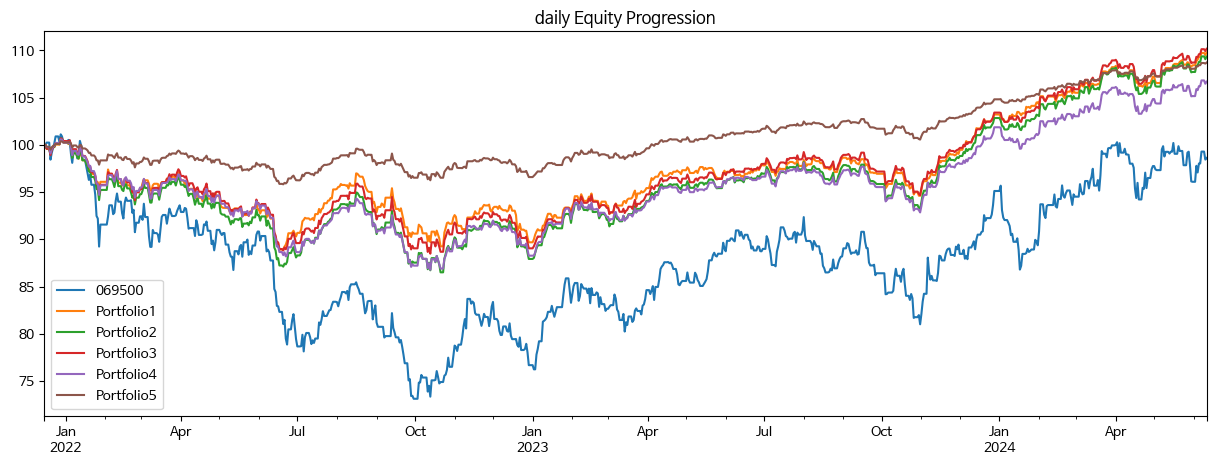

In [107]:
results = bt.run(*pf_val.values())
results.plot(freq='d')
results.stats.loc[metrics]